# Evaluation

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [13]:
%matplotlib inline

from __future__ import division
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import brightside as bs
import numpy as np
import os
import experiments as exp
import experiments.evaluation as eeval
import experiments.utils as eutils
import ntcir
import ntcir.IO as IO
from matplotlib.colors import ListedColormap
import csv

import sklearn.metrics as metrics

def read_csv_results(fname):
    frames = list()
    groundtruth = list()
    predictions = list()
    with open(fname, 'rb') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        for row in csv_reader:
            user_id, date, ind, gt, prediction = row
            frames.append((user_id, date, int(ind)))
            groundtruth.append(int(gt))
            predictions.append(int(prediction))            
    return frames, groundtruth, predictions

# Defining colormap for confusion matrices plots
cmap = list(reversed(sns.color_palette("RdBu", 40).as_hex()))
cmap = ListedColormap(cmap)

In [3]:
users = IO.load_annotations(ntcir.filepaths)
categories = IO.load_categories(ntcir.filepaths)
sorted_users = ntcir.utils.sort(users)

# Full day sequences
num_frames_per_day = 2880
sequences = ntcir.get_sequences(sorted_users, num_frames_per_day)

Forcing keras to use CPU

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:
from keras import backend as K

In [6]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.8):
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [7]:
KTF.set_session(get_session())

### VGG-16

In [7]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/test/',
                target_size=(224, 224),
                batch_size=1)

model = exp.vgg_16_second_phase_model('weights.VGG-16.best.tf.hdf5')

Found 2582 images belonging to 21 classes.


In [7]:
groundtruth = list()
predictions = list()
for i, (img, target) in enumerate(test_generator):
    if i == test_generator.n:
        break
    prediction = model.predict(img)
    predictions.append(np.argmax(prediction))
    groundtruth.append(np.argmax(target))
    
predictions = np.asarray(predictions)
groundtruth = np.asarray(groundtruth)

np.savetxt('VGG16.test.txt', np.vstack((groundtruth, predictions)).T, delimiter=",")

In [23]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

def load_image(image_data_generator, image, target_size=(224, 224)):    
    image_shape = target_size + (3,)
    batch_x = np.zeros((1,) + image_shape, dtype=K.floatx())
    img = load_img(image.path, target_size=target_size, grayscale=False)
    x = img_to_array(img)
    x = image_data_generator.random_transform(x)
    x = image_data_generator.standardize(x)
    batch_x[0,:] = x
    return batch_x

test_set = ntcir.read_split('test_split.txt')

frames = list()
groundtruth = list()
predictions = list()
for user_id, date in test_set:
    for ind, image in enumerate(users[user_id][date].images):
        img = load_image(test_datagen, image)        
        prediction = model.predict(img)
        predictions.append(np.argmax(prediction))
        groundtruth.append(image.label)
        frames.append((user_id,date, ind))

with open('VGG16.test.csv','w') as csv_file:
    for i, (user_id,date,ind) in enumerate(frames):
        csv_file.write("{},{},{},{},{}".format(user_id,date,ind,groundtruth[i],predictions[i]))
        csv_file.write('\n')    

In [7]:
vgg16_results = np.loadtxt('VGG16.test.txt', delimiter=',')
groundtruth, predictions = np.split(vgg16_results, 2, axis=1)
accuracy = metrics.accuracy_score(groundtruth, predictions)

<brightside.Attribute instance at 0x7f02811355a8>

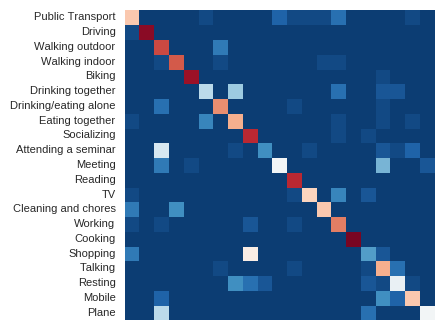

In [8]:
bs.print_attribute('Accuracy: ', accuracy)
fig, ax = bs.show_confusion_matrix(groundtruth, predictions, categories, (5,4), cmap=cmap, ticks_size=8, show_xticks=False, show_yticks=True, cbar=False)
plt.savefig('confusion_matrix_VGG16.eps', format='eps', dpi=300, bbox_inches='tight')

In [16]:
results = eeval.evaluate(groundtruth, predictions)
for metric, value in results.iteritems():
    if not isinstance(value, np.ndarray):
        bs.print_attribute(' '.join(metric.split('_')).title() + ':', value)        

<brightside.Attribute instance at 0x7f0280c8cea8>

<brightside.Attribute instance at 0x7f0280c8cea8>

<brightside.Attribute instance at 0x7f0280c8cea8>

<brightside.Attribute instance at 0x7f0280c8cea8>

### VGG-16+LSTM

In [8]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

### VGG-16+LSTM Timestep 10

In [4]:
test_set = ntcir.read_split('test_split.txt')

test_batches = ntcir.get_batches(test_set, sequences, include_last=True)

In [9]:
K.set_learning_phase(False)

model = exp.vgg_16_plus_lstm(weights='weights.VGG-16+LSTM.timesteps_10.lr_0.0001.00.tf.hdf5')

In [10]:
timesteps = 10

groundtruth = list()
predictions = list()
for i, batch in enumerate(test_batches):
    x, y = eutils.load_images_batch(test_datagen, users, batch, batch_size=timesteps)
    
    prediction = model.predict_on_batch(x)
    prediction = np.argmax(prediction,axis=2).squeeze()[0:batch.size]
    
    predictions.extend(prediction)
    groundtruth.extend(np.argmax(y,axis=2).squeeze()[0:batch.size])

predictions = np.asarray(predictions)
groundtruth = np.asarray(groundtruth)

np.savetxt('VGG16+LSTM.timestep_'+str(timesteps)+'.test.txt', np.vstack((groundtruth, predictions)).T, delimiter=",")

In [18]:
timesteps=10
vgg16_plus_lstm_results = np.loadtxt('VGG16+LSTM.timestep_'+str(timesteps)+'.test.txt', delimiter=',')
groundtruth, predictions = np.split(vgg16_plus_lstm_results, 2, axis=1)
accuracy = metrics.accuracy_score(groundtruth, predictions)

<brightside.Attribute instance at 0x7f0280ca2488>

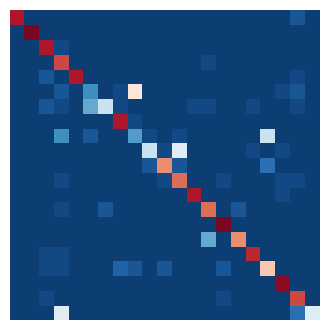

In [19]:
bs.print_attribute('Accuracy: ', accuracy)
fig, ax = bs.show_confusion_matrix(groundtruth, predictions, categories, (5,4), cmap=cmap, ticks_size=8, show_xticks=False, show_yticks=False, cbar=False)
plt.savefig('confusion_matrix_VGG16+LSTM.eps', format='eps', dpi=300, bbox_inches='tight')

In [20]:
results = eeval.evaluate(groundtruth, predictions)
for metric, value in results.iteritems():
    if not isinstance(value, np.ndarray):
        bs.print_attribute(' '.join(metric.split('_')).title() + ':', value)

<brightside.Attribute instance at 0x7f0312ee1368>

<brightside.Attribute instance at 0x7f0312ee1368>

<brightside.Attribute instance at 0x7f0312ee1368>

<brightside.Attribute instance at 0x7f0312ee1368>

### VGG-16+LSTM Timestep 5

In [9]:
test_set = ntcir.read_split('test_split.txt')

test_batches = ntcir.get_batches(test_set, sequences, batch_size=5, include_last=True)

In [10]:
K.set_learning_phase(False)

model = exp.vgg_16_plus_lstm(weights='weights.VGG-16+LSTM.timesteps_5.lr_2.5e-05.03.tf.hdf5',timestep=5)

In [12]:
timesteps = 5

frames = list()
groundtruth = list()
predictions = list()
for i, batch in enumerate(test_batches):
    x, y = eutils.load_images_batch(test_datagen, users, batch, batch_size=timesteps)
    
    prediction = model.predict_on_batch(x)
    prediction = np.argmax(prediction,axis=2).squeeze()[0:batch.size]
    
    predictions.extend(prediction)
    groundtruth.extend(np.argmax(y,axis=2).squeeze()[0:batch.size])
    
    for ind in batch.indices:
            frames.append((batch.user_id,batch.date,ind))

with open('VGG16+LSTM.timestep_'+str(timesteps)+'.test.csv','w') as csv_file:
    for i, (user_id,date,ind) in enumerate(frames):
        csv_file.write("{},{},{},{},{}".format(user_id,date,ind,groundtruth[i],predictions[i]))
        csv_file.write('\n')

In [19]:
timesteps = 5        
fname = 'VGG16+LSTM.timestep_'+str(timesteps)+'.test.csv'
frames, groundtruth, predictions = read_csv_results(fname)
accuracy = metrics.accuracy_score(groundtruth, predictions)

<brightside.Attribute instance at 0x7f583c7d1050>

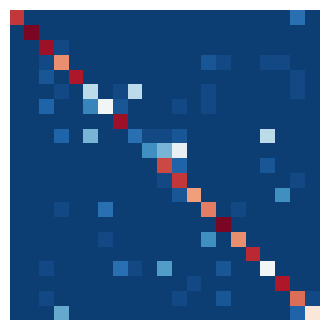

In [20]:
bs.print_attribute('Accuracy: ', accuracy)
fig, ax = bs.show_confusion_matrix(groundtruth, predictions, categories, (5,4), cmap=cmap, ticks_size=8, show_xticks=False, show_yticks=False, cbar=False)
plt.savefig('confusion_matrix_VGG16+LSTM.timestep_5.eps', format='eps', dpi=300, bbox_inches='tight')

In [21]:
results = eeval.evaluate(groundtruth, predictions)
for metric, value in results.iteritems():
    if not isinstance(value, np.ndarray):
        bs.print_attribute(' '.join(metric.split('_')).title() + ':', value)

<brightside.Attribute instance at 0x7f5844075b00>

<brightside.Attribute instance at 0x7f5844075b00>

<brightside.Attribute instance at 0x7f5844075b00>

<brightside.Attribute instance at 0x7f5844075b00>

### Filtered VGG-16+LSTM

In [7]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
test_set = ntcir.read_split('test_split.txt')
test_batches = ntcir.get_piggyback_batches(test_set, sequences, batch_size=10, overlap=3, training=False)

In [9]:
K.set_learning_phase(False)

model = exp.filtered_vgg_16_plus_lstm(weights='weights.Filtered_VGG16+LSTM.timesteps_10.overlap_3.lr_0.000050.04.tf.hdf5')

In [19]:
timestep = 10
overlap = 3
num_classes = 21
non_overlapping = timestep - overlap

mask = np.ones((1, timestep, num_classes))
prev_values = np.zeros((1, timestep, num_classes))

frames = list()
groundtruth = list()
predictions = list()
for day_batches in test_batches:
    break
    mask[:, :overlap, :] = 1
    prev_values[:, :overlap, :] = 0
    
    for batch in day_batches:
        x, y = eutils.load_images_batch(test_datagen, users, batch, batch_size=timestep)
        
        if batch.size == timestep:
            num_frames = non_overlapping
        else:
            num_frames = batch.size
                            
        prediction = model.predict_on_batch([x, mask, prev_values])
        class_prediction = np.argmax(prediction,axis=2).squeeze()[:num_frames]
    
        for ind in batch.indices[:num_frames]:
            frames.append((batch.user_id,batch.date, ind))
        
        predictions.extend(class_prediction)
        groundtruth.extend(np.argmax(y,axis=2).squeeze()[:num_frames])
    
        mask[:, :overlap, :] = 0
        prev_values[:, :overlap, :] = prediction[:, -overlap:, :]
        
predictions = np.asarray(predictions)
groundtruth = np.asarray(groundtruth)

np.savetxt('Filtered_VGG16+LSTM.timestep_'+str(timestep)+'.overlap_'+str(overlap)+'.test.txt', np.vstack((groundtruth, predictions)).T, delimiter=",")

In [24]:
timestep=10
overlap=3
vgg16_plus_lstm_results = np.loadtxt('Filtered_VGG16+LSTM.timestep_'+str(timestep)+'.overlap_'+str(overlap)+'.test.txt', delimiter=',')
groundtruth, predictions = np.split(vgg16_plus_lstm_results, 2, axis=1)
accuracy = metrics.accuracy_score(groundtruth, predictions)

IndexError: tuple index out of range

In [22]:
results = eeval.evaluate(groundtruth, predictions)
for metric, value in results.iteritems():
    if not isinstance(value, np.ndarray):
        bs.print_attribute(' '.join(metric.split('_')).title() + ':', value)

<brightside.Attribute instance at 0x7f23683a5a28>

<brightside.Attribute instance at 0x7f23683a5a28>

<brightside.Attribute instance at 0x7f23683a5a28>

<brightside.Attribute instance at 0x7f23683a5a28>

<brightside.Attribute instance at 0x7f23701f2050>

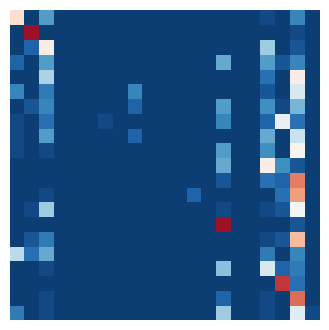

In [18]:
timestep = 10
overlap = 3
bs.print_attribute('Accuracy: ', accuracy)
fig, ax = bs.show_confusion_matrix(groundtruth, predictions, categories, (5,4), cmap=cmap, ticks_size=8, show_xticks=False, show_yticks=False, cbar=False)
plt.savefig('confusion_matrix_Filtered_VGG16+LSTM.eps', format='eps', dpi=300, bbox_inches='tight')

In [22]:
def show_sequences(groundtruth, predictions, labels):
    
    # Creating colormap
    colors = sns.color_palette("hls", len(labels))
#     np.random.shuffle(colors)
    labels_colors = {i: (label, colors[i]) for i, label in enumerate(sorted(labels))}

    true_ind = len(labels)
    false_ind = len(labels)+1
    
    labels_colors[true_ind] = ('True Prediction', (251/255, 48/255, 72/255))
    labels_colors[false_ind] = ('False Prediction', (0, 48/255, 203/255))
    
    sequences = -np.ones((2, len(groundtruth)), np.int)
    for i, (g, p) in enumerate(zip(groundtruth, predictions)):
        sequences[0,i] = g
        sequences[1,i] = true_ind if p == g else false_ind

    fig, ax = bs.show_sequences(sequences,labels_colors, figsize=(13,1), 
                                mask_value=-1, yticklabels=['Groundtruth', 'Prediction'],
                                xticklabels=50, leg_square_size=6, show_box=True, plot_xlabel='Frame')

    plt.show()   

In [23]:
print frames[0]

for i, (user_id, date, ind)

('u1', '2015-03-14', 0)


In [42]:
from collections import defaultdict

frames_dict = defaultdict(lambda: defaultdict(list))
groundtruth_dict = defaultdict(lambda: defaultdict(list))
predictions_dict = defaultdict(lambda: defaultdict(list))
for i, (user_id, date, ind) in enumerate(frames):
    frames_dict[user_id][date].append(ind) 
    groundtruth_dict[user_id][date].append(groundtruth[i])
    predictions_dict[user_id][date].append(predictions[i])

frames_dict = ntcir.utils.default_to_regular(frames_dict)
groundtruth_dict = ntcir.utils.default_to_regular(groundtruth_dict)
predictions_dict = ntcir.utils.default_to_regular(predictions_dict)

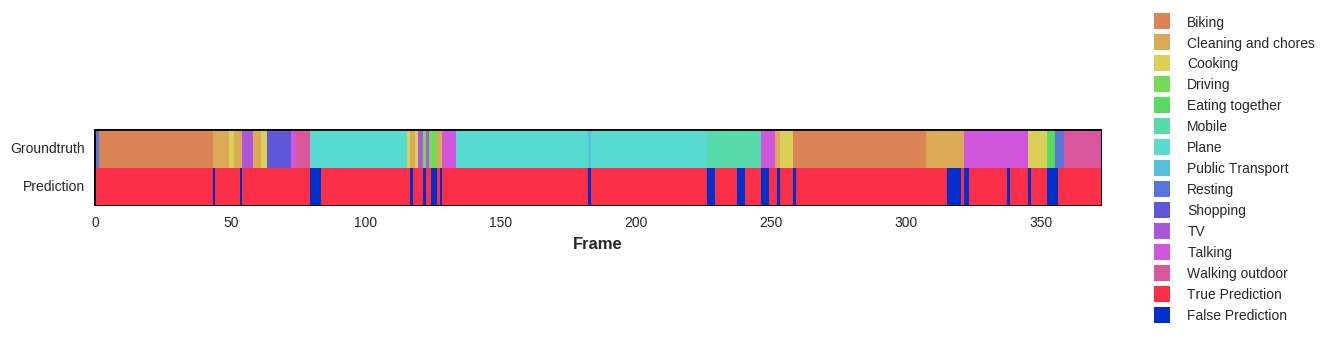

In [47]:
user_id = 'u1'
date = '2015-03-12'
show_sequences(groundtruth_dict[user_id][date],predictions_dict[user_id][date],categories)
fig.savefig('{}_{}_predictions.png'.format(user_id,date), bbox_inches = 'tight', format='png', dpi=150)